In [75]:
import csv
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import requests
import datetime as dt
from enum import Enum
%matplotlib inline

In [87]:
# WORKFLOW CONFIGURATION
# If True, does not attempt to make any API calls, and instead uses the raw API
# results stored in cached JSON files in the same directory as this notebook.
# Useful if running the notebook locally or if API is not available. If False, 
# calls the APIs and overwrites the JSON files in this directory. 
USE_CACHED_API_RESULTS = False

# API CONFIGURATION
# If desired, these timestamps can be modified to rerun the workflow over 
# different time windows.
EARLIEST_TIMESTAMP, LATEST_TIMESTAMP = "2007010100", "2018100100"

# CSV CONFIGURATION
# Column names for the CSV file.
YEAR, MONTH = "year", "month"
CTR_LGC_ALL = "pagecount_all_views"
CTR_LGC_DTP = "pagecount_desktop_views"
CTR_LGC_MBL = "pagecount_mobile_views"
CTR_PGV_ALL = "pageview_all_views"
CTR_PGV_DTP = "pageview_desktop_views"
CTR_PGV_MBL = "pageview_mobile_views"
# String constants declared just to avoid typos.
LEGACY, PAGEVIEW, DESKTOP, MOBILE = "legacy", "pageview", "desktop", "mobile"
# Data structures to organize and map the column names for easy handling later.
# Map the api type to its associated total sum counter 
SUM_CTR = {LEGACY : CTR_LGC_ALL, PAGEVIEW : CTR_PGV_ALL}
# Map the api and platform types to their associated individual counters.
INDIV_CTR = {LEGACY : {DESKTOP : CTR_LGC_DTP, MOBILE : CTR_LGC_MBL},
            PAGEVIEW : {DESKTOP : CTR_PGV_DTP, MOBILE : CTR_PGV_MBL}}
# Order the column names that are counters for easy iteration.
CSV_COUNTERS = [CTR_LGC_ALL, 
                CTR_LGC_DTP, 
                CTR_LGC_MBL, 
                CTR_PGV_ALL, 
                CTR_PGV_DTP, 
                CTR_PGV_MBL]
# Order all of the headers for the CSV file according to the required spec.
CSV_HEADERS = [YEAR, MONTH] + CSV_COUNTERS


# API CONSTANTS
HEADERS = {'User-Agent': 'https://github.com/joshua-bone',
           'From': 'joshbone@uw.edu'}
JSON_FILENAME_FORMAT = "{}_{}_{}-{}.json"
CSV_FILENAME_FORMAT = "en-wikipedia_traffic_{}-{}.csv"
LGC_DTP, LGC_MBL = "desktop-site", "mobile-site"
PGV_DTP, MBL_WEB, MBL_APP = "desktop", "mobile-web", "mobile-app"
LGC_ACCESS = [LGC_DTP, LGC_MBL]
PGV_ACCESS = [PGV_DTP, MBL_WEB, MBL_APP]
DTP_ACCESS = [LGC_DTP, PGV_DTP]
PROJECT, GRANULARITY = "en.wikipedia.org", "monthly"

# Explicitly filter out bot traffic (in the Pageviews API only).
AGENT = "user"

ENDPOINT_LGC = ('https://wikimedia.org/api/rest_v1/'
                   'metrics/legacy/pagecounts/aggregate/'
                   '{project}/{access-site}/{granularity}/{start}/{end}')

ENDPOINT_PGV = ('https://wikimedia.org/api/rest_v1/'
                      'metrics/pageviews/aggregate/'
                      '{project}/{access}/{agent}/{granularity}/{start}/{end}')

# ARTIFACT CONSTANTS
TITLE="Page Views On English Wikipedia (x 1,000,000)"
XLABEL="Year"
YLABEL="Views"
VIZ_FILENAME = "hcds-a1-visualization.png"

In [91]:
# Constructs a set of parameters for calling either of the two APIs. The API to
# call is inferred from the access level. 
def params(access, start, end):
  result = {"project" : PROJECT,
            "granularity" : GRANULARITY,
            "start" : start,
            "end" : end}
  if access in LGC_ACCESS:
    result["access-site"] = access
  else:
    result["access"] = access
    result["agent"] = AGENT
  return result

# Calls the correct API for the given access level. Optional parameters 'start'
# and 'end' can be used to modify the time window if needed.
def call_api(access, start = EARLIEST_TIMESTAMP, end = LATEST_TIMESTAMP):
  endpoint = ENDPOINT_LGC if access in LGC_ACCESS else ENDPOINT_PGV
  return requests.get(endpoint.format(**params(access, start, end)), 
                      headers=HEADERS).json()

# Returns a 6-digit integer representing the year and month from a string
# timestamp [for example, year_and_month_from("2010060800") = 201006].
def year_and_month_from(timestamp):
  return int(timestamp) // 10000 # use integer division

# Constructs a correctly formatted JSON filename for the given parameters.
def json_filename(access, start = EARLIEST_TIMESTAMP, end = LATEST_TIMESTAMP):
  api = "pagecounts" if access in LGC_ACCESS else "pageviews"
  return JSON_FILENAME_FORMAT.format(api, 
                                     access, 
                                     year_and_month_from(start), 
                                     year_and_month_from(end) - 1)

# Constructs a correctly formatted CSV file name for the given parameters.
def csv_filename(start = EARLIEST_TIMESTAMP, end = LATEST_TIMESTAMP):
  return CSV_FILENAME_FORMAT.format(year_and_month_from(start), 
                                    year_and_month_from(end) - 1)

# Calls the correct API for the given access level, and writes a JSON file with
# a correctly formatted filename.
def call_api_and_write_raw_data(access):
  api_result = call_api(access)
  with open(json_filename(access), "w") as f:
    f.write(json.dumps(api_result))
    
if not USE_CACHED_API_RESULTS:
  # Call the appropriate API for each of the five access levels, and write the
  # raw data to JSON.
    for access in LGC_ACCESS+PGV_ACCESS: call_api_and_write_raw_data(access)

In [92]:
# Extract the string year and month values from a string timestamp.
year_from = lambda timestamp : timestamp[0:4]
month_from = lambda timestamp : timestamp[4:6]

# Initialize a new row with zeroed counters for a timestamp
def new_csv_row_from_timestamp(timestamp):
  row = {YEAR: year_from(timestamp), MONTH: month_from(timestamp)}
  row.update({counter : 0 for counter in CSV_COUNTERS})
  return row

# Return the CSV counters to increment for a given access level. For example,
# access 'mobile-app' should increment both 'pageview_mobile_views' and 
# 'pageview_all_views'
def counters_to_increment(access):
  api = LEGACY if access in LGC_ACCESS else PAGEVIEW
  platform = DESKTOP if access in DTP_ACCESS else MOBILE
  return [SUM_CTR[api], INDIV_CTR[api][platform]]

In [93]:
# Read the raw data in from JSON files
raw_data = {}
for access in LGC_ACCESS + PGV_ACCESS:
  with open(json_filename(access), "r") as f:
    raw_data[access] = json.load(f)

cleaned_data = {}
# Loop through all five access levels.
for access in raw_data:
  # Loop through all buckets in each access level. Each bucket contains one
  # month of data.
  for bucket in raw_data[access]['items']:
    timestamp = bucket['timestamp']

    # The two APIs have different headers for total count. Make sure we get the
    # right one.
    count = bucket['count'] if access in LGC_ACCESS else bucket['views']
    
    # Initialize a new row with zeroed counters if we haven't seen this 
    # timestamp yet.
    if timestamp not in cleaned_data:
      cleaned_data[timestamp] = new_csv_row_from_timestamp(timestamp)
      
    # Increment the correct counters for this access level with the count from
    # this api bucket.
    csv_row = cleaned_data[timestamp]
    for counter in counters_to_increment(access):
      csv_row[counter] += count // 1_000_000 # Record views by millions

# Write cleaned data to CSV
with open(csv_filename(), 'w') as f:
  writer = csv.writer(f)
  
  # Write the column names to the first row in the CSV file.
  writer.writerow(CSV_HEADERS)
  
  # Loop through each month of cleaned data in increasing chronological order.
  for timestamp in sorted(cleaned_data.keys()):
    
    # Write the values for each month to the CSV file, in the same order as the
    # column names were written.
    row = map(lambda column : cleaned_data[timestamp][column], CSV_HEADERS)
    writer.writerow(row)

In [94]:
first_of_year = lambda t : pd.Timestamp(t.year, 1, 1)
first_of_next_year = lambda t : pd.Timestamp(t.year + 1, 1, 1)

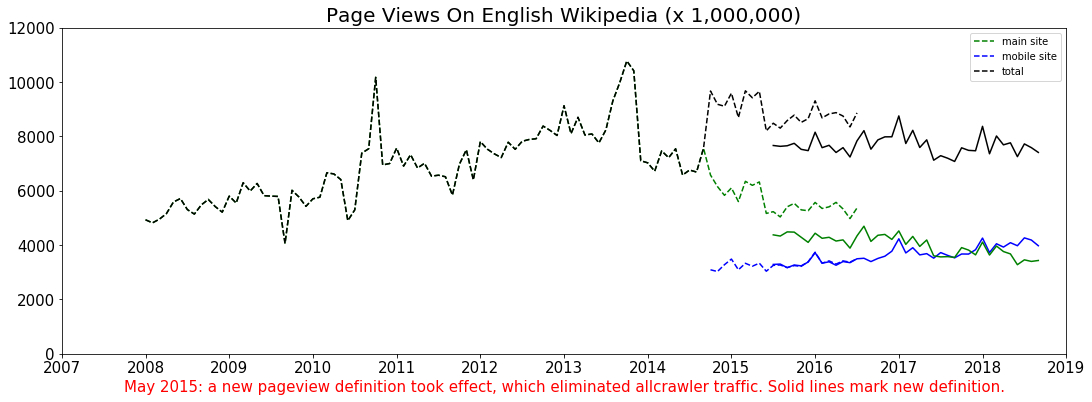

In [95]:
DATE = "Date"
fig, ax = plt.subplots()
TITLE_FONT_SIZE = 20
LABEL_FONT_SIZE = 15
INFO = 'May 2015: a new pageview definition took effect, which eliminated all' \
       + 'crawler traffic. Solid lines mark new definition.'


# The first and last buckets returned by the legacy API show much lower numbers
# than the other buckets, likely because data was recorded for only part of the
# month. We remove these numbers to avoid having distracting dips in the plot.
LGC_PARTIAL_DATES = ["2007-12-01", "2016-08-01"]

# Read cleaned data from CSV
df = pd.read_csv(csv_filename())

# Construct a new column from the year and month of the old column
df[DATE] = df.apply(lambda row : dt.datetime(row[YEAR], row[MONTH], 1), axis=1)
df.drop([YEAR, MONTH], axis=1, inplace=True)
df.replace(0, np.nan, inplace=True)

# Remove all legacy numbers for 2016-08-01 since it is a partial month.
legacy_counters = [CTR_LGC_ALL, CTR_LGC_DTP, CTR_LGC_MBL]
for partial_date in LGC_PARTIAL_DATES:
  df.loc[df[DATE] == partial_date, legacy_counters] = np.nan

# Dynamically set the bounds for x- and y- axes.
xmin = first_of_year(df[DATE].min())
xmax = first_of_next_year(df[DATE].max())
# For the y-axis, round the maximum value in the data to the nearest 1000, and 
# then add 1000 to define the upper bound for the y-axis.
ymax = round(df.loc[:, df.columns[0:6]].max().max(), -3) + 1000

# The x-axis should have ticks for the beginning of each year.
xticklabels = range(xmin.year, xmax.year + 1)
xticks = [pd.Timestamp(year, 1, 1) for year in xticklabels]

# Define the date column to be along the x-axis.
df.set_index(DATE, inplace=True)

# Prepare to plot the data.
colors = ['k', 'g', 'b'] * 2
line_styles = np.repeat(['--', '-'], [3, 3])
x = fig.set_size_inches(18, 6)
# Reverse everything so that the 'total' lines end up on top of the 'mobile'
# and 'desktop' lines. Plot the data.
for column, style, color in zip(reversed(df.columns[0:6]), 
                             reversed(line_styles), 
                             reversed(colors)):
  df[column].plot(style=style+color,
                  ax=ax, 
                  xticks=xticks, 
                  xlim=(xmin, xmax),
                  ylim=(0, ymax))
  
# Adjust the axes, title, font sizes, and legends. 
ax.set_xticklabels(xticklabels, fontsize=LABEL_FONT_SIZE)
for tick in ax.yaxis.get_major_ticks():
  tick.label.set_fontsize(LABEL_FONT_SIZE)
ax.set_title(TITLE, fontsize=TITLE_FONT_SIZE)
plt.xlabel(INFO, color='red',  fontsize=LABEL_FONT_SIZE)
legend = ax.legend((ax.lines[4], ax.lines[3], ax.lines[5]), 
              ('main site', 'mobile site', 'total'))
p = plt.setp(legend.get_title(), fontsize=LABEL_FONT_SIZE)

# Save the final product.
plt.savefig(VIZ_FILENAME)
